In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/train_test/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import re
import string   
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-

In [3]:
columns = ["Id","Entity","Target","Text"]
data = pd.read_csv("train_test/twitter_training.csv",
                   names=columns,header=None)

In [4]:
data.head()

,Id,Entity,Target,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
df = data[["Text","Target"]]

In [6]:
df.head()

,Text,Target
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


In [7]:
df.shape

(74682, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    73996 non-null  object
 1   Target  74682 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [9]:
df= df.drop_duplicates()

<AxesSubplot:xlabel='Target', ylabel='count'>

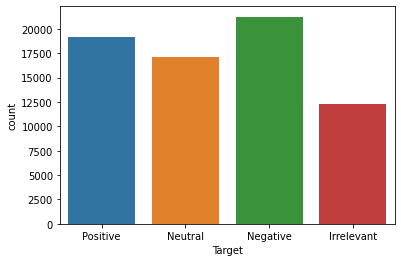

In [10]:
sns.countplot(x="Target",data=df)

In [11]:
sentiment = []

for i in df["Target"]:
    if i == "Positive":
        sentiment.append(1)
    elif (i == "Irrelevant") or (i == "Neutral"):
        sentiment.append(0)
    else:
        sentiment.append(-1)
df["Sentiment"] = sentiment

In [12]:
df.head()

,Text,Target,Sentiment
0,im getting on borderlands and i will murder yo...,Positive,1
1,I am coming to the borders and I will kill you...,Positive,1
2,im getting on borderlands and i will kill you ...,Positive,1
3,im coming on borderlands and i will murder you...,Positive,1
4,im getting on borderlands 2 and i will murder ...,Positive,1


In [13]:
stop_words = set(stopwords.words("english"))

## Text Cleaner

In [14]:
df["Text"] = df["Text"].str.replace("\d","")

In [15]:
def cleaner(data):
    # Tokens
    tokens = word_tokenize(str(data).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w.isalpha()]
    
    # Stopwords
    without_sw = [t for t in without_punc if t not in stop_words]
    
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_sw]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    
    return " ".join(text_cleaned)

In [16]:
df["Text"] = df["Text"].apply(cleaner)
df["Text"].head()

0     im get borderland murder
1             come border kill
2       im get borderland kill
3    im come borderland murder
4     im get borderland murder
Name: Text, dtype: object

In [17]:
df["Text"]=df["Text"].str.replace("im","")
df["Text"].head()

0      get borderland murder
1           come border kill
2        get borderland kill
3     come borderland murder
4      get borderland murder
Name: Text, dtype: object

## Rare Words

In [18]:
rare_words = pd.Series(" ".join(df["Text"]).split()).value_counts()
rare_words

game              10787
play               6822
get                5567
like               5153
go                 4216
                  ...  
bfpbldsiv             1
socool                1
bugbear               1
lingueoflegend        1
cennit                1
Length: 22234, dtype: int64

In [19]:
rare_words = rare_words[rare_words <= 2]

In [20]:
df["Text"] = df["Text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))

## Word Cloud

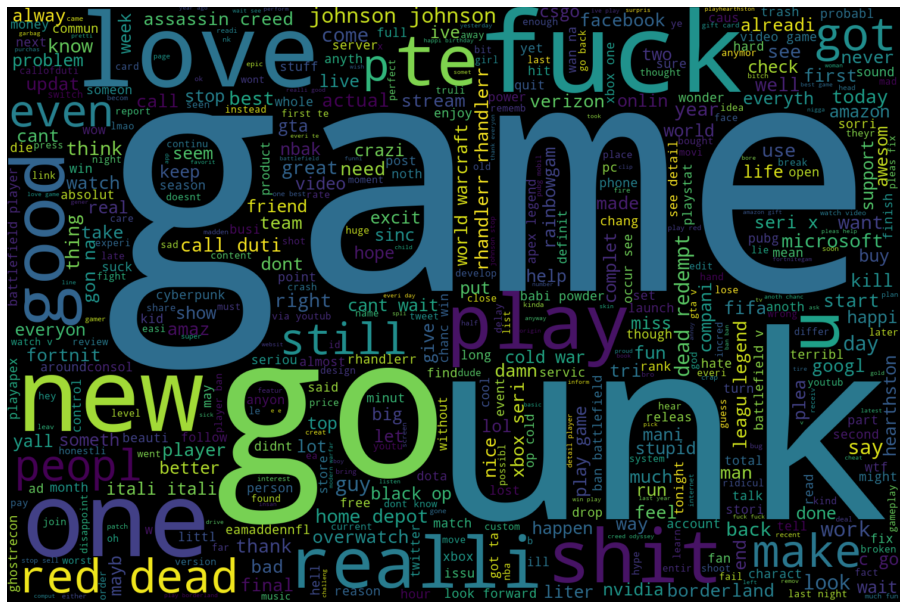

In [21]:
plt.figure(figsize=(16,12))
wordcloud = WordCloud(background_color="black",max_words=500, width=1500, height=1000).generate(' '.join(df['Text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Train test split

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.ensemble import RandomForestClassifier

In [23]:
X = df["Text"]
y = df["Sentiment"]

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state= 42)

## Count Vectorizer

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

In [27]:
print(X_train_count.toarray())
X_train_count

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<52329x14142 sparse matrix of type '<class 'numpy.int64'>'
	with 515139 stored elements in Compressed Sparse Row format>

## MultinomialNB

In [28]:
nb_model = MultinomialNB()
nb_model.fit(X_train_count,y_train)

MultinomialNB()

In [29]:
nb_pred = nb_model.predict(X_test_count)
nb_train_pred = nb_model.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.72      0.77      0.75      5284
           0       0.78      0.71      0.74      7360
           1       0.70      0.73      0.71      4800

    accuracy                           0.74     17444
   macro avg       0.73      0.74      0.73     17444
weighted avg       0.74      0.74      0.74     17444

X Train
              precision    recall  f1-score   support

          -1       0.76      0.81      0.78     15954
           0       0.81      0.75      0.78     22036
           1       0.74      0.77      0.75     14339

    accuracy                           0.77     52329
   macro avg       0.77      0.78      0.77     52329
weighted avg       0.78      0.77      0.77     52329



<AxesSubplot:>

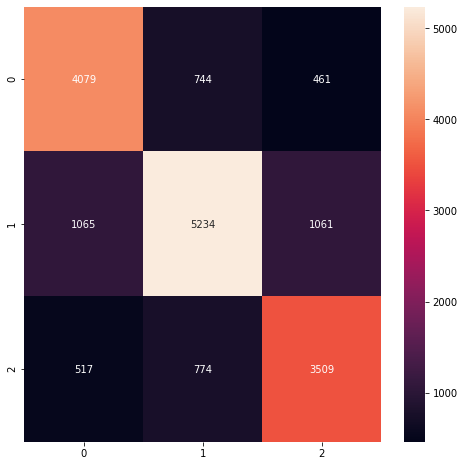

In [30]:
print("X Test")
print(classification_report(y_test,nb_pred))
print("X Train")
print(classification_report(y_train,nb_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,nb_pred),annot = True,fmt = "d")

In [31]:
from yellowbrick.classifier import PrecisionRecallCurve

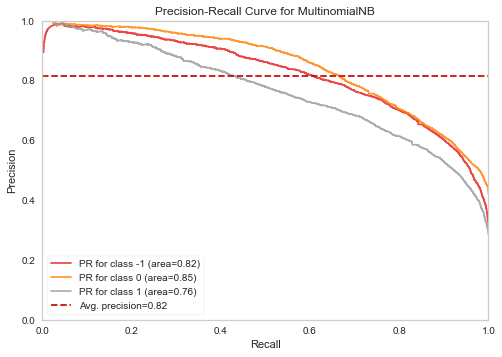

In [32]:
viz = PrecisionRecallCurve(MultinomialNB(),
                           classes=nb_model.classes_,   # label ların isimleri ile gözükmesi için yoksa 0,1,2 gözükür 
                           per_class=True,  # bütün class lar grafikte gözüksün diye True yaptık.
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)  # test datası üzerinden skorları alıyoruz
viz.show();

## Random Forest

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
rf_params = {"max_depth": [2,4,6,10,12],
            "max_features": [2,5,7],
            "n_estimators":[12,15,16,]}
rf = RandomForestClassifier()

In [35]:
rf_model_cv = GridSearchCV(rf,rf_params,cv = 5,n_jobs = -1)

In [36]:
rf_model_cv.fit(X_train_count,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 10, 12],
                         'max_features': [2, 5, 7],
                         'n_estimators': [12, 15, 16]})

In [37]:
rf_model_cv.best_params_

{'max_depth': 12, 'max_features': 5, 'n_estimators': 12}

In [38]:
rf_tuned = RandomForestClassifier(max_depth = 12,
                                 max_features = 7,
                                 min_samples_split = 2).fit(X_train_count,y_train)

In [39]:
rf_pred = rf_tuned.predict(X_test_count)
rf_train_pred = rf_tuned.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      5284
           0       0.42      1.00      0.59      7360
           1       0.00      0.00      0.00      4800

    accuracy                           0.42     17444
   macro avg       0.14      0.33      0.20     17444
weighted avg       0.18      0.42      0.25     17444

X Train
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     15954
           0       0.42      1.00      0.59     22036
           1       0.00      0.00      0.00     14339

    accuracy                           0.42     52329
   macro avg       0.14      0.33      0.20     52329
weighted avg       0.18      0.42      0.25     52329



<AxesSubplot:>

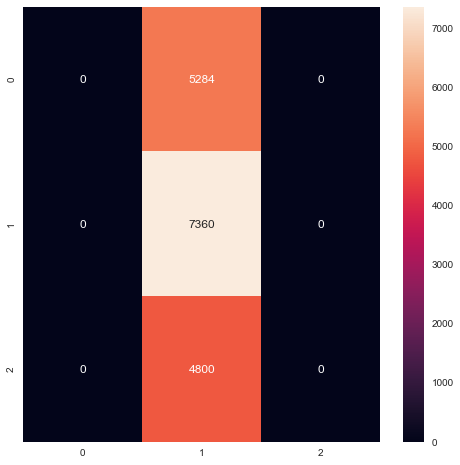

In [40]:
print("X Test")
print(classification_report(y_test,rf_pred))
print("X Train")
print(classification_report(y_train,rf_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,rf_pred),annot = True,fmt = "d")

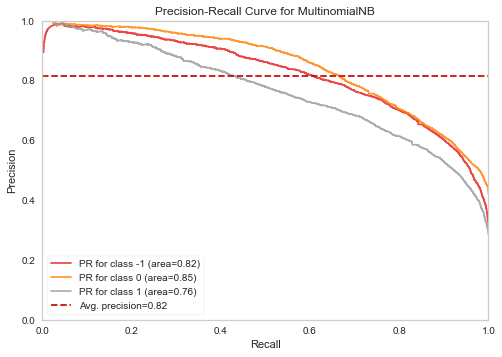

In [41]:
viz = PrecisionRecallCurve(MultinomialNB(),
                           classes=rf_tuned.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

## KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
knn = KNeighborsClassifier()

In [44]:
knn_model = knn.fit(X_train_count,y_train)

In [45]:
knn_pred = knn_model.predict(X_test_count)
knn_train_pred = knn_model.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.82      0.90      0.86      5284
           0       0.89      0.84      0.86      7360
           1       0.84      0.83      0.84      4800

    accuracy                           0.85     17444
   macro avg       0.85      0.86      0.85     17444
weighted avg       0.86      0.85      0.85     17444

X Train
              precision    recall  f1-score   support

          -1       0.90      0.95      0.92     15954
           0       0.94      0.92      0.93     22036
           1       0.92      0.91      0.92     14339

    accuracy                           0.92     52329
   macro avg       0.92      0.93      0.92     52329
weighted avg       0.93      0.92      0.92     52329



<AxesSubplot:>

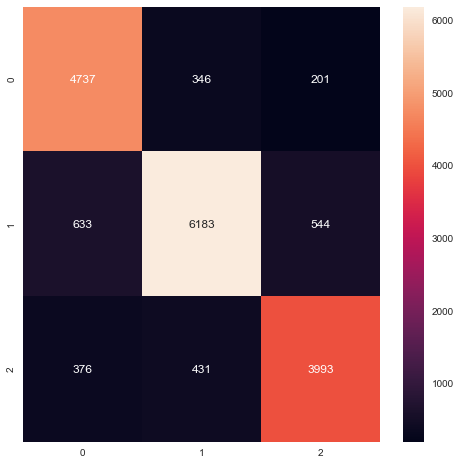

In [46]:
print("X Test")
print(classification_report(y_test,knn_pred))
print("X Train")
print(classification_report(y_train,knn_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,knn_pred),annot = True,fmt = "d")

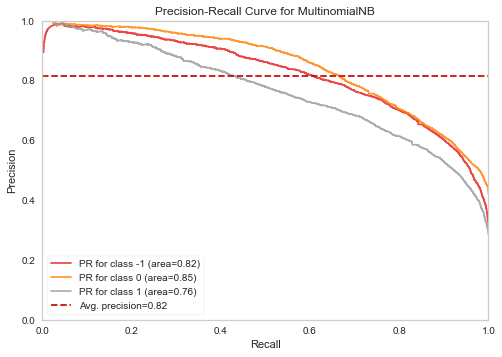

In [47]:
viz = PrecisionRecallCurve(MultinomialNB(),
                           classes=knn_model.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [48]:
pred_df = pd.DataFrame({"MultinomialNB":[accuracy_score(y_test,nb_pred)],
                      "Random Forest": [accuracy_score(y_test,rf_pred)],
                      "KNN": [accuracy_score(y_test,knn_pred)]})

train_pred = pd.DataFrame({"MultinomialNB":[accuracy_score(y_train,nb_train_pred)],
                      "Random Forest": [accuracy_score(y_train,rf_train_pred)],
                      "KNN": [accuracy_score(y_train,knn_train_pred)]})

<AxesSubplot:>

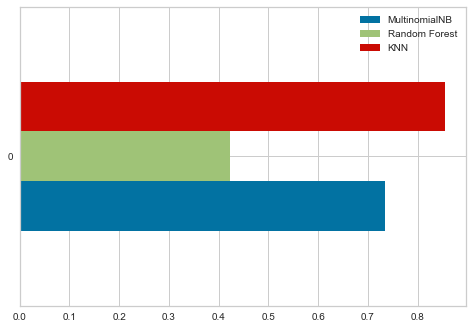

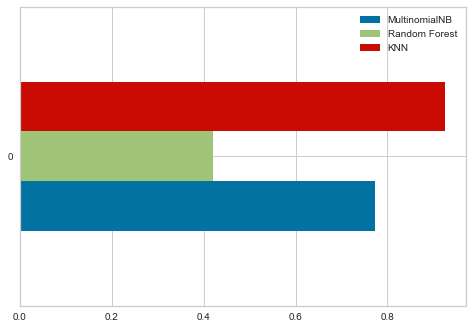

In [49]:
pred_df.plot(kind="barh")
train_pred.plot(kind="barh")